# <center> Gradient Descent </center>
<center> Corinne Jones, TA </center>
<center> DATA 558, Spring 2019 </center>

In this lab we will discuss gradient descent and how to apply it to a simple function. After this lab, you should know the following:

- How gradient descent works
- How to choose a step size in gradient descent using two different methods

## 0 Review
Last week's introduction to Python included `for` loops and functions. For example, if we wanted to compute the Euclidean distance between two vectors, we could use the function below. The input `y` to the function is optional and the default value is (0,0).

In [1]:
# These lines just tell the notebook to display all of the results.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np

def euclidean_distance(x, y=np.array([0,0])):
  dist = np.sqrt(sum((x-y)**2))
  return dist

euclidean_distance(np.array([1,1]), np.array([2,1]))
euclidean_distance(np.array([1,1]), np.array([0,0]))
euclidean_distance(np.array([1,1]))

1.0

1.4142135623730951

1.4142135623730951

**Exercise 1**
Write a function called `linreg` that will compute the linear regression coefficients given a matrix $X$ of predictors and a vector $y$ of responses. I.e., write a function that given $X$ and $y$ will return $(X^TX)^{-1}X^Ty$. Hint: To compute $A^{-1}b$ for a matrix $A$ and vector $b$, you can use np.linalg.solve(A,b). 

Test your function using the code below.

In [3]:
def linreg(x, y):
    return np.linalg.solve(x.T.dot(x),x.T.dot(y))

In [4]:
# Some code to check your results
import matplotlib.pyplot as plt
# Create some data 
np.random.seed(0)
X = np.random.normal(scale=2, size=(50, 1))
X = np.hstack((np.ones_like(X), X))
epsilon = np.random.normal(size=50)
y = 1 + 2*X[:, 1] + epsilon

# Get estimated betas from your function
betas = linreg(X, y)
print('Estimated betas =', betas)  # Are they close to (1, 2)?

plt.scatter(X[:, 1], y)
xs = np.arange(np.min(X[:, 1]), np.max(X[:, 1]), 0.1)
plt.plot(xs, betas[0]+betas[1]*xs)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regression line you fit to the data')
plt.show()

Estimated betas = [0.98546499 1.97720451]


Text(0.5, 0, 'x')

Text(0, 0.5, 'y')

Text(0.5, 1.0, 'Regression line you fit to the data')

<Figure size 640x480 with 1 Axes>

## 1 Gradient Descent
Gradient descent is one of the simplest methods to find a minimum of a function. Recall that the gradient of a differentiable function $f$ at a point $x$ is a vector pointing in the direction of greatest increase from $x$. Hence, when minimizing a function starting at some point $x_0$, it makes sense to repeatedly take steps in the direction of greatest decrease (the opposite direction of the gradient). In other words, we use the following scheme:

> `Input:` $x_0$ (initial starting point)  
> `While not converged:`  
>  $ \qquad x_k = x_{k-1} - t_{k}\nabla f(x_{k-1})$  
> `Output:` $x_K$ (where $K$ is the index of the final iteration)

There are several ways to choose the step size $t_k$, two of which are described in detail later. One option is a constant step size, where the constant is chosen appropriately. The convergence criterion is typically taken to be that the norm of the gradient is sufficiently small.

Another viewpoint of gradient descent is that at each step $k$ we're minimizing the following quadratic approximation to $f$ at $x_k$:
$$f(x) \approx f(x_k)+\nabla f(x_k)^T(x-x_k)+\frac{1}{2t_k}\|x-x_k\|^2.$$

For linear regression $f$ will be our linear regression objective function. Let's try gradient descent on a simple example though first before applying it to linear regression. 

Consider the function $f(x_1, x_2) = x_1^2+x_2^2+x_1x_2$. We can obtain the gradient by differentiating with respect to $x_1$ and $x_2$:
\begin{align*}
\frac{\partial f}{\partial x_1} &= 2x_1+x_2\\
\frac{\partial f}{\partial x_2} &= 2x_2+x_1,
\end{align*}
so
\begin{align*}
\nabla f(x_1,x_2) = 
\begin{bmatrix}
2x_1+x_2 \\
2x_2+x_1
\end{bmatrix}.
\end{align*}

Hence, since here $x=(x_1,x_2)$, the gradient descent update will be
\begin{align*}
\begin{bmatrix}
x_{1,k} \\
x_{2,k}
\end{bmatrix}
= 
\begin{bmatrix}
x_{1, k-1} \\
x_{2, k-1}
\end{bmatrix}
-
t_k \begin{bmatrix}
2x_{1,k-1}+x_{2,k-1} \\
2x_{2,k-1}+x_{1,k-1}
\end{bmatrix}.
\end{align*}

Let's code this now. We'll make the code fairly general so we can reuse it in the future. For illustration purposes I'm going to store all of the points we step to along the way, but in general you may not want to do this, as it slows down the algorithm.


**Exercise 2**
Write a function called `obj` that takes in a vector $x=[x_1, x_2]$ and returns the value of the objective function from above. 

In [5]:
def obj(x):
    return (x[0]**2 + x[1]**2 + x[0]*x[1])

**Exercise 3** Write a function called `grad` that takes in a vector $x=[x_1, x_2]$ and returns the gradient of the objective function from above. 

In [6]:
def grad(x):
    return np.array([2*x[0]+x[1], 2*x[1]+x[0]])

**Exercise 4** Fill in the gradient descent step in the function grad_descent below. (In this function I store the value of $x$ at each step for use later.)
Check your functions using the plotting functions I provided below.

In [7]:
def grad_descent(x_init, t, eps=0.001, max_iter=1000):
    """
    Run gradient descent with a fixed step size
    Inputs:
      - x_init: Starting point
      - t: Step size (a constant)
      - eps: Value for convergence criterion for the the norm of the gradient.
      - max_iter: Maximum number of iterations to perform
    Output:
      - x_vals: Matrix of estimated x's at each iteration,
                with the most recent values in the last row.
    """
    x = x_init
    grad_x = grad(x)
    x_vals = [x]
    iter = 0
    while np.linalg.norm(grad_x) > eps and iter < max_iter:
        # FILL IN THE GRADIENT DESCENT STEP HERE. It will update the variable x
        # using the step size t and gradient grad_x.
        x = x-t*grad_x
        x_vals.append(x)
        grad_x = grad(x)
        iter += 1
        
    return np.array(x_vals)

In [8]:
def contour_plot(x_vals, xmin, xmax, ymin, ymax):
    """
    Make a contour plot of the results
    Inputs:
      - x_vals: Locations the gradient descent algorithm stepped to
      - xmin, xmax: x-axis limits
      - ymin, ymax: y-axis limits
    """
    # Check that the inputs are 2-dimensional
    assert(x_vals.ndim == 2)
    assert(x_vals.shape[1] == 2)
    
    # Create grid of values
    x = np.linspace(xmin, xmax)
    y = np.linspace(ymin, ymax)
    grid = np.dstack(np.meshgrid(x,y)).reshape((-1, 2)).T
    # Evaluate the objective function at each point on the grid
    f = obj(grid)
    # Make a contour plot of the function
    plt.contour(x, y, f.reshape((len(x), len(y))))
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Gradient descent convergence', fontsize=16)
    # Add the locations of the points the algorithm visited
    jet = plt.get_cmap('jet')
    colors = jet(np.linspace(0, 1, len(x_vals)))
    plt.scatter(x_vals[:, 0], x_vals[:, 1], c=colors, marker='x')
    plt.show()
    

In [9]:
def convergence_plots(x_vals):
    """
    Plot the convergence in terms of the function values and the gradients
    Input:
      - x_vals: Values the gradient descent algorithm stepped to
    """
    n, d = x_vals.shape
    fs = np.zeros(n)
    grads = np.zeros((n, d))
    for i in range(n):
        fs[i] = obj(x_vals[i])
        grads[i, :] = grad(x_vals[i])
    grad_norms = np.linalg.norm(grads, axis=1)
    plt.subplot(121)
    plt.plot(fs)
    plt.xlabel('Iteration')
    plt.ylabel('Objective value')

    plt.subplot(122)
    plt.plot(grad_norms)
    plt.xlabel('Iteration')
    plt.ylabel('Norm of gradient')

    plt.suptitle('Function Value and Norm of Gradient Convergence', fontsize=16)
    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

    plt.show()

If we want to start at $(1, 0.5)$ and our convergence criterion is that $\|\nabla f(x)\|<0.01$, then we can run our gradient descent function using the code below. We can also plot the results using a contour plot, since our function's inputs are two-dimensional. The more common plots of convergence are also included.

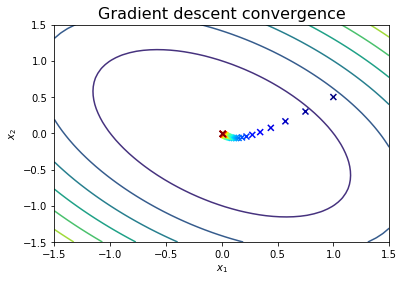

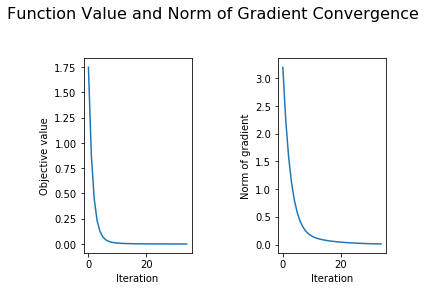

In [10]:
x_init = np.array([1, 0.5])
t = 0.1
x_vals = grad_descent(x_init, t, eps=0.01)

# Make a contour plot with the results
contour_plot(x_vals, -1.5, 1.5, -1.5, 1.5)

# Make usual convergence plots
convergence_plots(x_vals)

**Exercise 5** What if we choose a much larger step size? Try running gradient descent with `t=10` and `max_iter=5`. What happens?

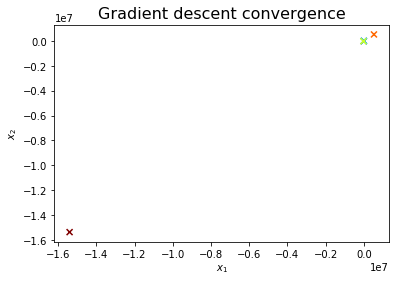

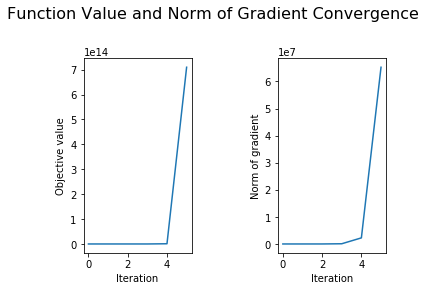

In [11]:
x_init = np.array([1, 0.5])
t = 10
x_vals = grad_descent(x_init, t, eps=0.01, max_iter=5)

# Make a contour plot with the results
contour_plot(x_vals, -1.5, 1.5, -1.5, 1.5)

# Make usual convergence plots
convergence_plots(x_vals)

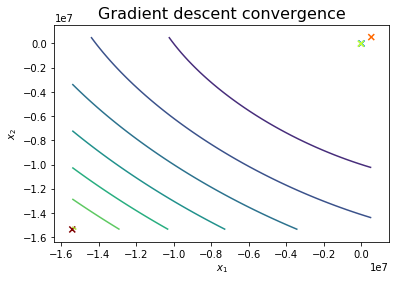

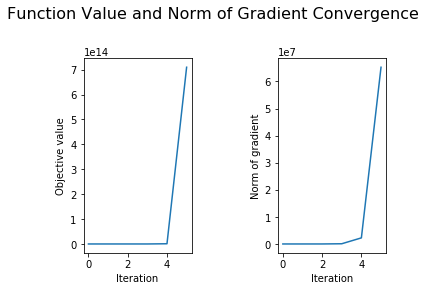

In [12]:
# Make a contour plot with the results
contour_plot(x_vals, min(x_vals[:, 0]), max(x_vals[:, 0]),  min(x_vals[:, 1]), max(x_vals[:, 1]))

# Make usual convergence plots
convergence_plots(x_vals)

This brings us back to the question "How can we choose an appropriate step size?" There are many ways to do this, two of which I will explain:
- Using the Lipschitz constant of the gradient, or an upper bound on it (assuming the gradient is indeed Lipschitz)
- Performing backtracking line search

### 1.1 Constant step size
We say that the gradient of a function $f$ is $L-$Lipschitz if
$$\|\nabla f(x) - \nabla f(x')\| \leq L\|x-x'\| \text{ for all } x,x' \text{ in the domain of } f.$$
This is basically saying that the gradient doesn't change too quickly. If the function we're optimizing has a Lipschitz gradient, it turns out that $1/L$ is the optimal constant step size in gradient descent, where $L$ is the best (smallest) Lipschitz constant of the gradient.

**Exercise 6&ast;** Show that the Lipschitz constant of the function from above is 3.

&ast; denotes hard and/or time-consuming exercises that you can do later if you have time.

Let's try running gradient descent with this step size!

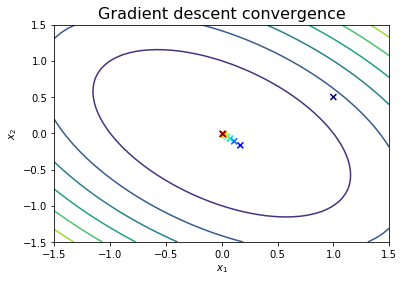

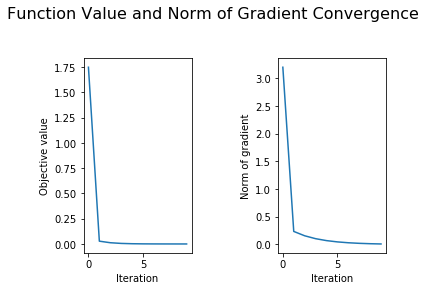

In [13]:
x_init = np.array([1,0.5])
t = 1/3.0  # 1/Lipschitz constant
x_vals = grad_descent(x_init, t, eps=0.01)
contour_plot(x_vals, -1.5, 1.5, -1.5, 1.5)
convergence_plots(x_vals)

From the plots above we can see that it converges much faster when we provide the Lipschitz constant to the algorithm. But what if we don't know the Lipschitz constant or if the function doesn't have a Lipschitz gradient? In that case we can use a line search method.

### 1.2 Inexact line search
An alternative to using a constant step size is to use a line search method. The idea is that we know we want to move in the direction $-\nabla f(x)$, but we don't know how far. Hence, we could systematically try some points in that direction and find one that will "work".

One commonly used line search method is called backtracking line search. It works as follows. We start with some upper bound $t$ (say, $t=1$) on how far we are going to step in the direction of the gradient. We then check if this leads to a sufficient decrease in the objective function. Specifically, we check whether the following relation is satisfied:
\begin{align*}
f(x-t\nabla f(x)) < f(x) - \alpha t \|\nabla f(x)\|^2_2
\end{align*}
for some parameter $\alpha$. If $t$ doesn't work, then we decrease $t$ by a factor of $\beta$ and check again. We repeat this until we find an appropriate $t$. We can take $\alpha=1/2$ and $\beta=1/2$, but in general we should have $\alpha\in(0,0.5]$ and $\beta\in(0,1)$. In picture form, we have something like Figure 1.

<figure>
<center>
  <img src="https://www.researchgate.net/profile/Seyed_Ali_Asghar_Beheshti/publication/255581774/figure/fig1/AS:347196156334080@1459789422711/backtracking-line-search-The-curve-shows-f-restricted-to-the-line-over-which-we-search.ppm" alt=""/>
    </center>
  <figcaption><P>Figure 1. Backtracking line search. The black curve is $f$ as a function of $t$, i.e., $f$ restricted to the line on which we are searching. The lower dashed line is the linear approximation to $f$ at $x$, and the upper line has a smaller slope. The backtracking condition is that we find a $t$ such that $f(x-t\nabla f(x))$ lies below the upper dashed line.</P></figcaption>
</figure>

Now we can code it. We need to change our original gradient descent algorithm to use backtracking line search instead of a constant step size.


**Exercise 7** Insert the code for the sufficient decrease condition in the `bt_line_search` function below, along with the update to `t`.

In [14]:
def bt_line_search(x, t=1, alpha=0.5, beta=0.5, max_iter=100):
    """
    Perform backtracking line search
    Inputs:
      - x: Current point
      - t: Starting (maximum) step size
      - alpha: Constant used to define sufficient decrease condition
      - beta: Fraction by which we decrease t if the previous t doesn't work
      - max_iter: Maximum number of iterations to run the algorithm
    Output:
      - t: Step size to use
    """
    grad_x = grad(x)  # Gradient at x
    norm_grad_x = np.linalg.norm(grad_x)  # Norm of the gradient at x
    found_t = False
    i = 0  # Iteration counter
    while (found_t is False and i < max_iter):
        # INSERT THE SUFFICIENT DECREASE CONDITION FOR BACKTRACKING LINE SEARCH IN THE
        # if STATEMENT BELOW IN PLACE OF "if True".      
        if obj(x-t*grad_x) < obj(x)-alpha*t*norm_grad_x**2:
            found_t = True
        elif i == max_iter - 1:
            raise('Maximum number of iterations of backtracking reached')
        else:
            t *= beta
            i += 1
    return t

**Exercise 8** Modify the gradient descent code below so it uses backtracking line search instead of a constant step size.

In [15]:
def grad_descent_bt(x_init, t_init=1, eps=0.001, max_iter=1000):
    """
    Run gradient descent with a fixed step size
    Inputs:
      - x_init: Starting point
      - t_init: Initial step size (a constant)
      - eps: Value for convergence criterion for the the norm of the gradient.
      - max_iter: Maximum number of iterations to perform
    Output:
      - x_vals: Matrix of estimated x's at each iteration,
                with the most recent values in the last row.
    """
    x = x_init
    grad_x = grad(x)
    x_vals = [x]
    iter = 0
    while np.linalg.norm(grad_x) > eps and iter < max_iter:
        # CHANGE THE CODE BELOW SO IT USES BACKTRACKING LINE SEARCH INSTEAD OF A CONSTANT STEP SIZE
        t = bt_line_search(x)
        x = x - t*grad_x
        x_vals.append(x)
        grad_x = grad(x)
        iter += 1
        
    return np.array(x_vals)

If we run our code, we get similar results as before, and it's also pretty fast.

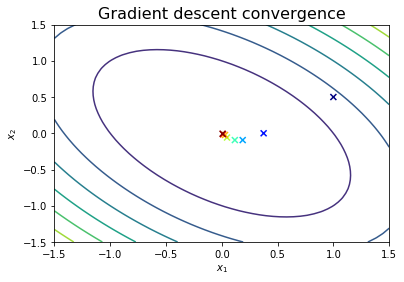

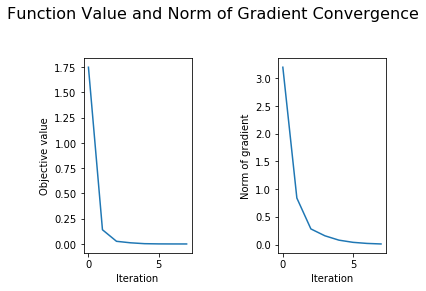

In [16]:
x_vals = grad_descent_bt([1, 0.5], eps=0.01)
contour_plot(x_vals, -1.5, 1.5, -1.5, 1.5)
convergence_plots(x_vals)